### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Friday, Feb 19th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

     |████████████████████████████████| 953 kB 2.8 MB/s eta 0:00:01
You should consider upgrading via the '/Users/dabbiecm/Documents/venv/bin/python -m pip install --upgrade pip' command.


In [12]:
import numdifftools as nd
import numpy as np
from scipy import optimize
from scipy.stats import norm
import corner
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,8

### Solution


## 1)

read in hw3_data_1.npy, using the rules for heteroscedastic Gaussian data, compute the sample mean and the standard error on the sample mean

For heteroscedastic Gaussian data (from Lecture 5),

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

In [2]:
data=np.load('../../homeworks/hw_data/hw3_data_1.npy',allow_pickle=True)

# first calculate sample mean
mu_num=0
mu_denom=0
for i in range(np.shape(data)[0]): #iterate over each data point
    
    mu_num+=(data[i][0])/(data[i][1]**2)
    mu_denom+=1/(data[i][1]**2)
    
mu_hat=mu_num/mu_denom

# next calculate standard error on sample mean
sigma_mu=mu_denom**-0.5

print("Sample Mean: {:.2f}".format(mu_hat))
print("Standard Error of Sample Mean: {:.2f}".format(sigma_mu))

Sample Mean: 3.92
Standard Error of Sample Mean: 0.09


SRT: Correct formula and answers, Collin. But "for" loops should be avoided in python unless absolutely necessary, since they slow everything down. np.sum operations over arrays are more compact and faster. -2

## 2)

write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean.

From Lecture 5.

$${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

In [3]:
def lnlike(mu,x,sigma): #x and sigma are vectors, mu is a float
    return np.sum([(x[i]-mu)**2/(2*sigma[i]**2) for i in range(len(x))])


f_lnlike = lambda mu: lnlike(mu,x=data[:,0],sigma=data[:,1])

mu0=2 #initial guess
mu_fit = optimize.fmin(f_lnlike, mu0)
print('###########################################')
print("Best-fit mean: {:.2f}".format(mu_fit[0]))

Optimization terminated successfully.
         Current function value: 43.162545
         Iterations: 18
         Function evaluations: 36
###########################################
Best-fit mean: 3.92


SRT: Yes, but you don't need the "for" loop inside the lnlike function. np.sum will do that for you. -1

## 3)

Compute the Fisher uncertainty estimate on the mean

In [4]:
# First sample lnlike over a range of mu estimates
index=np.linspace(start=0,stop=10,num=100)
lnlike_samples=np.asarray([lnlike(i,data[:,0],data[:,1]) for i in index])*-1

# Next do a rough 2nd order differentiation of our lnlike
sigma_mu = np.diff(lnlike_samples, n=2)
# Divide through by delta theta^2 to get normalization
# (in this case theta is mu)
sigma_mu /= (index[1]-index[0])**2
# multiply by -1 and take the square root
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Fisher matrix error on estimated mean is 0.095


## 4)

Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

In [5]:
def bootstrap(B,x,sigma):
    '''
    draw B bootstrap samples of dataset x with uncertainties sigma
    
    returns:
        samples - 3D array of shape (B,N,2) with B bootstrapped realizations of x and sigma
                  samples[i,:,0] is the ith bootstrap realization of x
                  samples[i,:,1] is the ith bootstrap realization of sigma
    '''
    N=len(x)
    samples=np.zeros(shape=(B,N,2))
    
    for i in range(B):
        idx_all=np.arange(N) # all indexes in x
        idx_choose=np.random.choice(idx_all,size=N,replace=True) #choose N samples from indexes with replacement
        samples[i,:,0]=x[idx_choose]
        samples[i,:,1]=sigma[idx_choose]
        
    return samples

bootstrap_samples=bootstrap(B=1000,x=data[:,0],sigma=data[:,1])


## 5)

Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

In [6]:
B=1000

bootstrap_mus=[]
for i in range(B):
    
    f_lnlike = lambda mu: lnlike(mu,x=bootstrap_samples[i,:,0],sigma=bootstrap_samples[i,:,1])
    mu0=2 #initial guess
    mu_fit = optimize.fmin(f_lnlike, mu0,disp=False)[0] #disp=False turns off print statements
    
    bootstrap_mus.append(mu_fit)
    
    
    

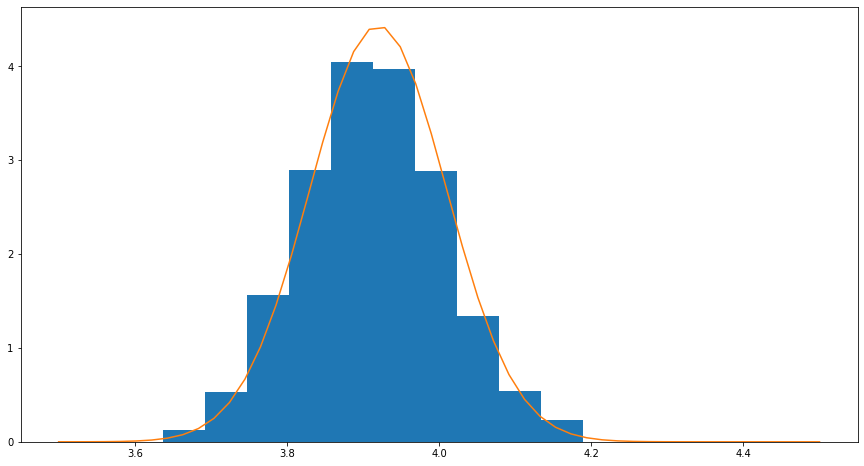

In [7]:
index=np.linspace(3.5,4.5,num=50)
pdf=norm(loc=3.92,scale=0.09).pdf(index)

_=plt.hist(bootstrap_mus,bins=10,density=True)
plt.plot(index,pdf)

# These seem to agree well

SRT: Very good!

## 6)

While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

For a Laplace distribution

$$ lnL= \frac{-1}{\Delta} \sum_{i=1}^N |x_i-\mu| -Nln2 - Nln\Delta$$

In [17]:
# beta=[mu,delta]
def lnlike_laplace(mu,delta,x):
    N=len(x)
    absolute=0
    for i in range(N):
        absolute+=np.absolute(x[i]-mu)
        
    return ((1/delta)*absolute)+(N*np.log(delta))+N*np.log(2)
        
# beta=[mu,delta]
f_laplace = lambda beta: lnlike_laplace(beta[0], beta[1], 
                                        x=data[:,0])

beta0 = (3, 1) # initial guess for mu and delta
beta_fit_laplace = optimize.fmin(f_laplace, beta0)

print("Best-fit mu: {:.2f}".format(beta_fit_laplace[0]))
print("Best-fit Delta: {:.2f}".format(beta_fit_laplace[1]))



Optimization terminated successfully.
         Current function value: 156.788916
         Iterations: 54
         Function evaluations: 100
Best-fit mu: 4.09
Best-fit Delta: 0.88


SRT: Good, but faster to use the scipy.stats laplace object.

## 7)

Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

From Lecture 6

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

where $k$ is the number of model parameters and $N$ is the number of data points.

In [9]:
N=len(data[:,0])

def AIC(lnL,k,N):
    return -2*lnL + 2*k + (2*k*(k+1))/(N-k-1)

lnL_laplace=-lnlike_laplace(4.09,0.88,data[:,0])
AIC_laplace=AIC(lnL_laplace,2,N)

lnL_gauss=-lnlike(3.92,data[:,0],data[:,1])
AIC_gauss=AIC(lnL_gauss,2,N)

print("AIC for Laplace distribution: {:.2f}".format(AIC_laplace))
print("AIC for Gaussian distribution: {:.2f}".format(AIC_gauss))

# The data favors a Gaussian distribution

AIC for Laplace distribution: 317.70
AIC for Gaussian distribution: 90.45


SRT: The number of parameters for the Gaussian is 1, not 2. -1

## 8)

Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

In [11]:
B=1000

bootstrap_laplace_mus=[]
bootstrap_laplace_deltas=[]
for i in range(B):
    
    # beta=[mu,delta]
    f_laplace = lambda beta: lnlike_laplace(beta[0], beta[1], 
                                            x=bootstrap_samples[i,:,0])

    beta0 = (3, 1) # initial guess for mu and delta
    beta_fit = optimize.fmin(f_laplace, beta0,disp=False) #disp=False turns off print statements
    
    bootstrap_laplace_mus.append(beta_fit[0])
    bootstrap_laplace_deltas.append(beta_fit[1])

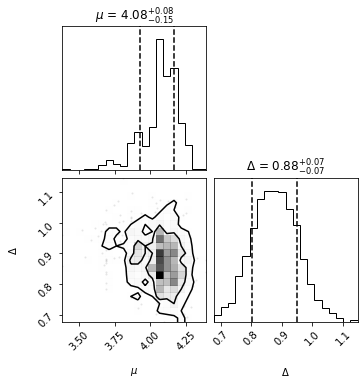

In [16]:
# corner wants shape (nsamples,ndim)

bootstrap_laplace=np.zeros(shape=(B,2))
bootstrap_laplace[:,0]=bootstrap_laplace_mus
bootstrap_laplace[:,1]=bootstrap_laplace_deltas

labels=[r'$\mu$',r'$\Delta$']

fig = corner.corner(bootstrap_laplace, 
                    labels=labels,
                    quantiles=(0.16, 0.84),
                    levels=(0.68,0.95),
                    show_titles=True, 
                    title_kwargs={"fontsize": 12})

## 9)

Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [21]:
H = nd.Hessian(f_laplace)([beta_fit_laplace[0], beta_fit_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

print(sigma_laplace)

# The Fisher uncertainties seem to be smaller than the bootstrapped uncertainties

[[0.09190364 0.00237374]
 [0.00237374 0.08822694]]


<ipython-input-17-436e9435c45d>:8: RuntimeWarning: invalid value encountered in log
  return ((1/delta)*absolute)+(N*np.log(delta))+N*np.log(2)


SRT: Very good.